In [1]:
import xarray as xr # needed for reading data
import pandas as pd # Used for stroing data
import numpy as np
import pickle as pkl  # Needed for saving model objects
import os
from itertools import repeat # Needed for repeating a variable multiple times

import matplotlib.pyplot as plt
import matplotlib as mpl

import statsmodels.api as sm    # Used for bot he SARIMA and SARIMAX models
import statsmodels.tsa as sm_tsa # Used for type checking SARIMA models
from sklearn import metrics     # Used for importing various performance measures
import seaborn as sns


In [2]:
# Depending on the machine on which the code is run, data might be stored in different directories.
# Indicate which machine is used to make sure the path to the data can be found.
# Can either be "local" or "Snellius"

MACHINE = 'local'

if MACHINE == 'Snellius':
    pred_var_path = '/gpfs/work1/0/ctdas/awoude/Ritten/predictor_vars/' # For retrieving the set of aggregated scaling vectors

    SAVE_DIR = pers_file_dir = '/gpfs/work1/0/ctdas/awoude/Ritten/trained_models/' # used for storing the trained model

    SF_DIR = '/gpfs/work1/0/ctdas/awoude/Ritten/fitted_sf/' # used for storing the scaling factor produced bij ML models

    RESULTS_DIR = '/gpfs/work1/0/ctdas/awoude/Ritten/results/' # used for storing the trained model

elif MACHINE == 'local':
    pred_var_path = './' # For retrieving the set of aggregated scaling vectors

    SAVE_DIR = pers_file_dir = './models/' # used for storing the trained model

    SF_DIR = './fitted_sf/' # used for storing the scaling factor produced bij ML models

    RESULTS_DIR = './results/'


SARIMA_params = {'order': (2,0,2),             # Defining the regular AR, I and MA dependencies
                 'seasonal_order': (1,0,1,52), # Defining the seasonal dependencies
                 'trend': 'c'                  # Adding an intercept term
                 }


['regions', 'grid_cell_weight', 'grid_cell_area', 'TER', 'monthly_flux', 'smoothed_flux', 'opt_flux', 'prior_flux_per_s', 'scaling_factor', 'sf_per_eco', 'monthly_sf', 'smoothed_sf', 'g10m_MAX', 'swvl1_MIN', 'swvl1_MAX', 'slhf_MIN', 'slhf_MAX', 'slhf_AVG', 'sshf_MIN', 'sshf_MAX', 'sshf_AVG', 'ssrd_MIN', 'ssrd_MAX', 'ssrd_AVG', 'u10m_AVG', 'v10m_AVG', 'blh_MAX', 'd2m_MIN', 'd2m_MAX', 'd2m_AVG', 'lsp_SUM', 'skt_MIN', 'skt_MAX', 'skt_AVG', 'src_MIN', 'src_AVG', 'ssr_MAX', 'ssr_AVG', 't2m_MIN', 't2m_MAX', 't2m_AVG', 'ci_AVG', 'cp_MAX', 'cp_SUM', 'sd_MIN', 'sd_MAX', 'sf_AVG', 'sf_MAX', 's10m_AVG', 'eco_area', 'tc_region']


In [3]:
with xr.open_dataset('./vars_per_eco_update.nc') as ds:
    var_dat = ds
var_dat['tc_region'] = xr.DataArray(data=((var_dat.eco_regions.values-1)/19).astype('int32')+1,
                                    dims=["eco_regions"],
                                    coords=dict(eco_regions=var_dat.eco_regions)
                                    )


In [4]:
for tc_region, tc_dat in var_dat.groupby('tc_region'):
    surface_percentage = (tc_dat.eco_area / np.sum(tc_dat.eco_area))*100
    print(f'\nsurface area tc region {tc_region}:')
    print(surface_percentage)
    print(f'present PFTs: {(surface_percentage.eco_regions.values)%19}')


surface area tc region 1:
<xarray.DataArray 'eco_area' (eco_regions: 11)>
array([22.922844  ,  5.863838  ,  0.5255304 , 33.6242    ,  0.289517  ,
       16.422295  ,  0.61264694,  3.1926877 ,  0.4102671 ,  3.5679374 ,
       12.568241  ], dtype=float32)
Coordinates:
  * eco_regions  (eco_regions) float64 1.0 3.0 4.0 7.0 ... 11.0 15.0 16.0 19.0
present PFTs: [ 1.  3.  4.  7.  8.  9. 10. 11. 15. 16.  0.]

surface area tc region 2:
<xarray.DataArray 'eco_area' (eco_regions: 16)>
array([14.020346  ,  2.3537915 ,  8.119455  , 21.94334   ,  0.50943077,
        3.6332946 ,  7.558173  ,  8.905615  , 10.844167  ,  0.5841603 ,
        0.19133204,  0.09890687, 17.183481  ,  0.64058447,  0.05794891,
        3.3559666 ], dtype=float32)
Coordinates:
  * eco_regions  (eco_regions) float64 20.0 21.0 22.0 23.0 ... 34.0 35.0 38.0
present PFTs: [ 1.  2.  3.  4.  5.  6.  7.  8. 10. 11. 12. 13. 14. 15. 16.  0.]

surface area tc region 7:
<xarray.DataArray 'eco_area' (eco_regions: 12)>
array([31.61549  ,  

/home/user/.pyenv/versions/MasterProject-3.9.2/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:278: UserWarning: 'color' and 'colormap' cannot be used simultaneously. Using 'color'
  warnings.warn(
/home/user/.pyenv/versions/MasterProject-3.9.2/lib/python3.9/site-packages/pandas/plotting/_matplotlib/style.py:123: UserWarning: 'color' and 'colormap' cannot be used simultaneously. Using 'color'
  warnings.warn(


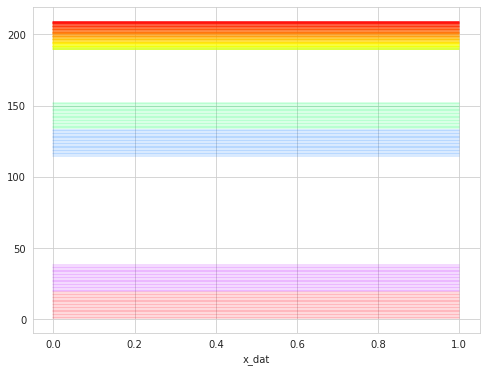

In [4]:

mock_regions = np.concatenate([range(1,20), range(20,39), range(115, 134), range(134, 153), range(190, 210)])

color_dat = np.interp(mock_regions, [1,19,20,38,115,133,134,152,190,209],
                   [0, 0,# color TC region 1
                    0.2, 0.2, # color TC region 2
                    0.4, 0.4, # color TC region 7
                    0.6, 0.6, # color TC region 8
                    0.8, 1]) # color range TC 11

mock_x = np.linspace(0, 1, 10)
first_entry = zip([mock_regions[0]]*len(mock_x), mock_x, [mock_regions[0]]*len(mock_x))
mock_df = pd.DataFrame(first_entry, columns=['region', 'x_dat', 'y_dat'])
for region in mock_regions[1:]:
    data_triples = zip([region]*len(mock_x), mock_x, [region]*len(mock_x))
    new_entry = pd.DataFrame(data_triples, columns=['region', 'x_dat', 'y_dat'])
    mock_df= pd.concat([mock_df, new_entry], ignore_index = True)
# continent_dict = {1:'North American Boreal',
#                    2:'North American Temperate',
#                    7:'Eurasia Boreal',
#                    8:'Eurasia Temperate',
#                    11:'Europe',
#                   }
# continent_to_index = {1:0,
#                    2:1,
#                    7:2,
#                    8:3,
#                    11:4,
#                   }

fig, ax = plt.subplots(figsize=(8,6))

#norm = mpl.colors.Normalize(vmin=0, vmax=12000, clip=True)
cmap = plt.get_cmap('RdYlGn_r')  # From red to green

# print(mock_df)
colors = plt.cm.hsv_r(color_dat)
alphas = [1 if r>=190 else 0.2 for r in mock_regions]

colors[:,-1] = alphas

mock_df = mock_df.set_index(['x_dat','region'])
mock_df.unstack(['region']).xs('y_dat', axis=1).plot(colormap='jet', color=colors, ax=ax, legend=False)
# mock_df.groupby('region').plot('x_dat', 'y_dat', cmap=cmap, ax=ax)
# cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap, norm=norm, orientation='vertical',
#                                 ticks=[100, 1000, 10000])
# cb1.set_clim(0,12000)
plt.show()

In [5]:
file_name = './fitted_sf/monthly_backup/monthly_1.0.nc'
with xr.open_dataset(file_name) as ds:
    monthly = ds.where(ds.testing_time.notnull(), drop=True)

print(monthly)

<xarray.Dataset>
Dimensions:           (time: 208, n_train_years: 17)
Coordinates:
  * time              (time) datetime64[ns] 2017-01-07 2017-01-14 ... 2020-12-26
  * n_train_years     (n_train_years) int32 1 2 3 4 5 6 7 ... 12 13 14 15 16 17
    eco_regions       float64 1.0
Data variables:
    prior_flux_per_s  (time) float32 1.718e+06 1.713e+06 ... 1.731e+06 1.727e+06
    sf_per_eco        (time) float32 0.246 0.8773 0.9208 ... 0.5112 0.2465
    optimized_flux    (time) float32 4.227e+05 1.503e+06 ... 8.849e+05 4.257e+05
    testing_time      (time) datetime64[ns] 2017-01-07 2017-01-14 ... 2020-12-26
    predicted_sf      (n_train_years, time) float32 0.4043 0.4043 ... 0.5239
    predicted_flux    (n_train_years, time) float32 6.947e+05 ... 9.046e+05
    training_time     (n_train_years, time) datetime64[ns] NaT NaT ... NaT NaT
    eco_area          (time) float64 2.315e+12 2.315e+12 ... 2.315e+12 2.315e+12
    tc_region         (time) float64 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.

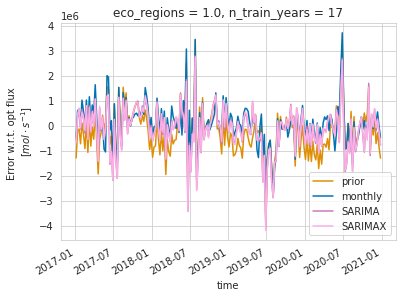

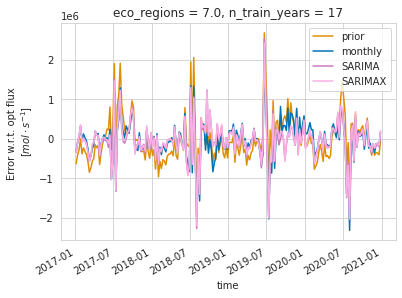

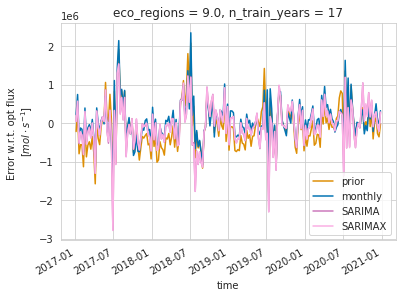

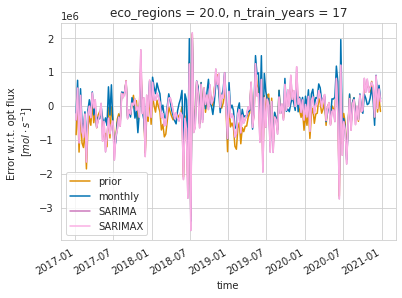

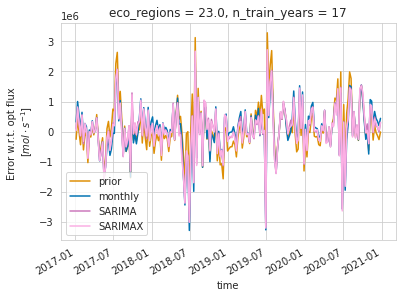

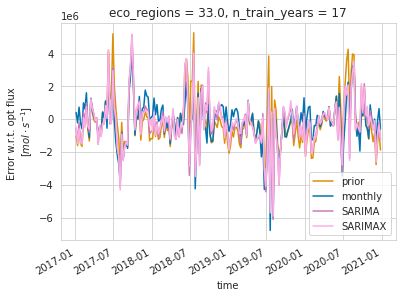

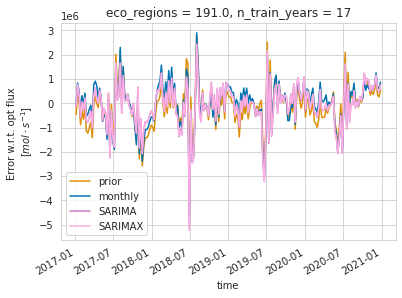

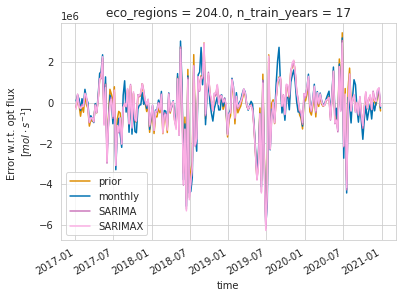

In [48]:
pal = sns.color_palette('colorblind')
# sns.mpl.rc("figure", figsize=(10,6))


plot_train = False

# specifiy the color of each tc_region.
model_color_dict = {'prior':1,
                 'smoothed':2,
                 'monthly':0,
                 'SARIMA':4,
                 'SARIMAX':6,
                 'target':7}

for region in [1.0, 7.0, 9.0, 20.0, 23.0, 33.0, 191.0, 204.0]:
    file_name = './fitted_sf/monthly_backup/monthly_'+ str(region) + '.nc'
    with xr.open_dataset(file_name) as ds:
        monthly = ds.where(ds.testing_time.notnull(), drop=True)

    file_name = './fitted_sf/SARIMA/SARIMA_'+ str(region) + '.nc'
    with xr.open_dataset(file_name) as ds:
        sarima = ds.where(ds.testing_time.notnull(), drop=True)

    file_name= './fitted_sf/SARIMAX/SARIMAX_'+ str(region) + '.nc'
    with xr.open_dataset(file_name) as ds:
        sarimax = ds.where(ds.testing_time.notnull(), drop=True)

    # monthly.optimized_flux.plot(label='opt')
    # xr.plot.scatter(monthly, x='time', y='optimized_flux', label='opt', color=pal[model_color_dict['target']])
    # plt.plot(monthly.time.values, np.ones(len(monthly.time.values)), label='prior', color=pal[model_color_dict['prior']])

    (monthly.optimized_flux - monthly.prior_flux_per_s).plot(label='prior', color=pal[model_color_dict['prior']])
    (monthly.optimized_flux - monthly.predicted_flux.loc[dict(n_train_years=17)]).plot(label='monthly', color=pal[model_color_dict['monthly']])
    (monthly.optimized_flux - sarima.predicted_flux.loc[dict(n_train_years=17)]).plot(label='SARIMA', color=pal[model_color_dict['SARIMA']])
    (monthly.optimized_flux - sarimax.predicted_flux.loc[dict(n_train_years=17)]).plot(label='SARIMAX', color=pal[model_color_dict['SARIMAX']])

    # plt.ylabel('scaling factor')
    # plt.ylabel('Total flux \n'+ r'[$mol\cdot s^{-1}$]')
    plt.ylabel('Error w.r.t. opt flux \n'+ r'[$mol\cdot s^{-1}$]')
    plt.legend()
    plt.show()




# print(prior_sf.where(prior_sf.testing_time.notnull(), drop=True))

In [3]:

def mol_per_sec_to_PgC_per_year(df):
    fac= 86400.*365.*12./1e15 # from mol/s to PgC/yr
    for var in ['flux_ME_test', 'flux_ME_train', 'flux_MAE_test', 'flux_MAE_train', 'flux_RMSE_test', 'flux_RMSE_train']:
        df[var] = df[var]*fac
    return df


def load_results(model_name):
    file_name = RESULTS_DIR + model_name + '_results_per_tc.pkl'
    df = pd.read_pickle(file_name)
    df = mol_per_sec_to_PgC_per_year(df)
    return df.set_index(['N_train_years','tc_region'])

used_models = ['SARIMA', 'SARIMAX', 'monthly', 'prior']

results_dict = {model_name: load_results(model_name) for model_name in used_models}

results_df = pd.concat(results_dict)

results_df.index.rename(['model', *list(results_df.index.names)[1:]], inplace=True)


In [33]:
results_df.loc[["monthly","prior", "SARIMA"], [1,5], [1.0, 2.0, 11.0]][['flux_ME_test', 'flux_RMSE_test']]

flux_ME_test  flux_RMSE_test
model   N_train_years tc_region                              
monthly 1             1.0            0.060040        0.711303
                      2.0            0.130314        1.248152
                      11.0          -0.224740        1.302173
        5             1.0            0.121000        0.587462
                      2.0            0.062588        0.997705
                      11.0          -0.166738        1.045579
prior   1             1.0           -0.289568        0.735037
                      2.0           -0.137117        1.226761
                      11.0          -0.313248        0.938297
        5             1.0           -0.289568        0.735037
                      2.0           -0.137117        1.226761
                      11.0          -0.313248        0.938297
SARIMA  1             1.0           -0.848510        2.252865
                      2.0           -0.132595        3.383676
                      11.0          -0.119398        2.562213
        5             1.0           -0.191816        0.659196
                      2.0           -0.125280        1.258667
                      11.0          -0.351156        1.225757

Bbox(x0=166.95, y0=805.2272727272727, x1=1270.5882352941176, y1=1491.0)
Bbox(x0=1283.622549019608, y0=805.2272727272727, x1=2301.3125, y1=1491.0)
Bbox(x0=2239.078431372549, y0=805.2272727272727, x1=3240.0, y1=1491.0)


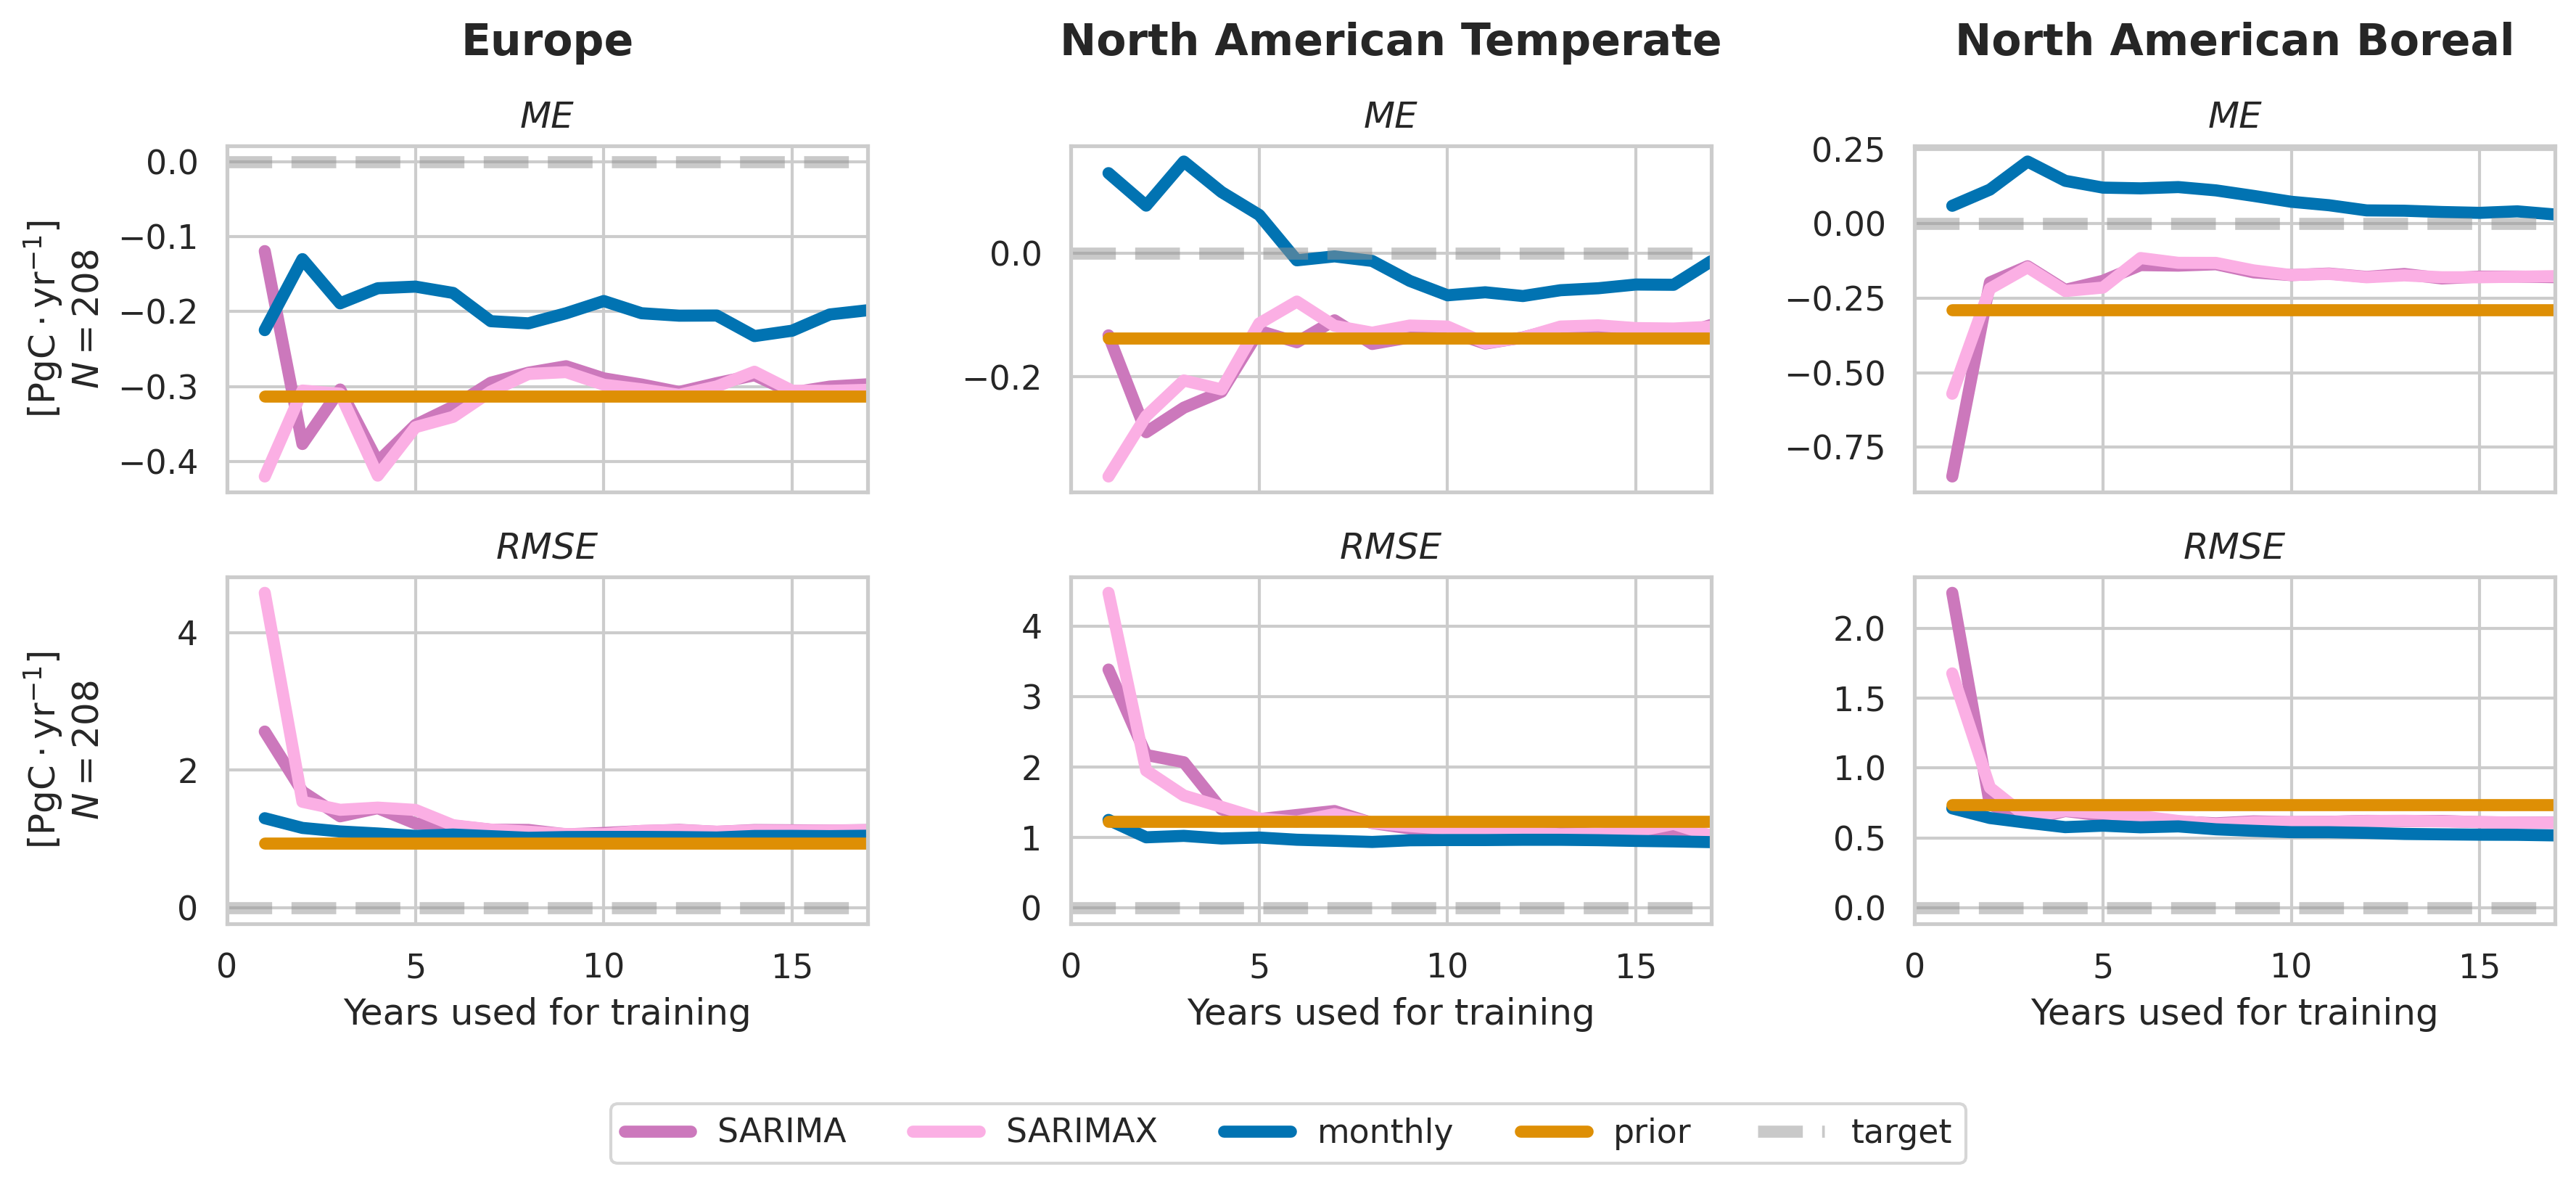

In [23]:
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage,
                                  AnnotationBbox)


used_perf_measures = ['ME', 'RMSE'] # options: ['ME', 'MAE', 'MAPE', 'RMSE', 'r2']

tc_subset = [11.0, 2.0, 1.0] # options: [1.0, 2.0, 7.0, 8.0, 11.0]

tc_groups = results_df.groupby(['tc_region'])
tc_groups = {tc: tc_groups.get_group(tc) for tc in tc_subset}
tc_regions = list(tc_groups.keys())

# tc_regions = [2.0, 11.0] # meaning the north american temperate and europe transCom regions


eval_space = 'flux' # options: 'flux' or 'sf

N_term = '\n'+r'$N=208$'

y_labels = {'flux':{'ME':   r'[$\mathrm{PgC\cdot yr^{-1}}$]'+N_term,
                    'MAE':  r'[$\mathrm{PgC\cdot yr^{-1}}$]'+N_term,
                    'MAPE': '[%]'+N_term,
                    'RMSE': r'[$\mathrm{PgC\cdot yr^{-1}}$]'+N_term,
                    'r2':   '[-]'+N_term},
            'sf':{'ME':     '[-]'+N_term,
                  'MAE':    '[-]'+N_term,
                  'MAPE':   '[%]'+N_term,
                  'RMSE':   '[-]'+N_term,
                  'r2':     '[-]'+N_term}}

# Because the R^2 performance measure needs to be interpreted differently, a dictionary is introduced describing the target value of each performance measure
var_target = {'ME':     0,
              'MAE':    0,
              'MAPE':   0,
              'RMSE':   0,
              'r2':     1}


x_label = 'Years used for training'


#sns.set(style="whitegrid", palette="pastel", color_codes=True)
sns.set(style="whitegrid", palette="colorblind", color_codes=True)
pal = sns.color_palette('colorblind')
# sns.mpl.rc("figure", figsize=(10,6))


plot_train = False
model_alpha_dict = {'prior':1, # alpha TC region 1
                   'CTE2018':1, # alpha TC region 2
                   'monthly':1, # alpha TC region 7
                   'SARIMA':1, # alpha TC region 8
                   'SARIMAX':1, # alpha TC region 11
                  }

# specifiy the color of each tc_region.
model_color_dict = {'prior':1,
                 'smoothed':2,
                 'monthly':0,
                 'SARIMA':4,
                 'SARIMAX':6}

color_indices = [model_color_dict[model] for model in used_models]

colors = [pal[c] for c in color_indices]
# print(colors)
alphas = [model_alpha_dict[model] for model in used_models]
# print(alphas)
colors = [mpl.colors.to_rgba(c, a) for c, a in zip(colors, alphas)]
# print(colors)
continent_dict = {1:'North American Boreal',
                   2:'North American Temperate',
                   7:'Eurasia Boreal',
                   8:'Eurasia Temperate',
                   11:'Europe',
                  }

n_rows = len(used_perf_measures)
n_cols = len(tc_regions)

fig, ax = plt.subplots(n_rows, n_cols,figsize=(n_cols*4,n_rows*2.5), sharex=True)

for j, (tc_region, tc_dat) in enumerate(tc_groups.items()):

    tc_dat.reset_index(inplace=True)
    tc_dat.set_index(['model', 'N_train_years'], inplace=True)
    for i, perf_mes in enumerate(used_perf_measures):
        tc_dat.unstack(['model']).xs(eval_space+'_'+perf_mes + '_test', axis=1).plot(color=colors, ax=ax[i][j], legend=False, linewidth = 4, sort_columns=True)

        if plot_train:
            tc_dat.unstack(['model']).xs(eval_space+'_'+perf_mes + '_train', axis=1).plot(color=colors, ax=ax[i][j], legend=False, linestyle=':', linewidth = 2, sort_columns=True)

        ax[i][j].set_title(perf_mes, style='italic')
        ax[i][j].set_title(perf_mes, style='italic')

for i, perf_mes in enumerate(used_perf_measures):
    ax[i][0].set_ylabel(y_labels[eval_space][perf_mes])
    for j in range(n_cols):
        ax[i][j].axhline(y=var_target[perf_mes], color=pal[7], alpha=0.5, linestyle='--', label='target', linewidth = 4)
        # ax[i][j].axhline(y=var_target[perf_mes], color=pal[7], alpha=0.5, linestyle='--', label='target', linewidth = 4)

# for i, perf_measures in enumerate(used_perf_measures):
    # ax[i][0].text(x = -0.8, y = 5, s = "row label", rotation = 90, va = "center")


# if 'r2' in used_perf_measures:
#     for j in range(n_cols):
#         ax[n_rows-1][j].axhline(y=1.0, color=pal[7], alpha=0.5, linestyle='--', label='target', linewidth = 4)
#         ax[n_rows-1][j].axhline(y=1.0, color=pal[7], alpha=0.5, linestyle='--', label='target', linewidth = 4)
# else:


pad = 30 # in points
#

figure_title = "Statevector space" if eval_space == 'sf' else "Flux space"
# ax[0][0].annotate(figure_title, xy=(.475, 1.2), xycoords='figure fraction',
#             horizontalalignment='center', verticalalignment='top',
#             fontsize=20)


col_names = [continent_dict[int(tc_region)] for tc_region in tc_regions]
for axes, col_name in zip(ax[0], col_names):
    axes.annotate(col_name, xy=(0.5, 1), xytext=(0, pad),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline', fontweight="bold")
for axes in ax[-1]:
    axes.set_xlabel(x_label)

# Annotate the 1st position with another text box ('Test')
# offsetbox = TextArea("Test")
#
# ab = AnnotationBbox(offsetbox, (0.5, 1),
#                     xybox=(1.02, xy[1]),
#                     xycoords='data',
#                     boxcoords=("axes fraction", "data"),
#                     box_alignment=(0., 0.5))
# ax.add_artist(ab)
#
# continent_dict = {1:'North American Boreal',
#                    2:'North American Temperate',
#                    7:'Eurasia Boreal',
#                    8:'Eurasia Temperate',
#                    11:'Europe',
#                   }

original_handles, original_labels = ax[0][0].get_legend_handles_labels()

len_legend = 2*len(used_models)+1 if plot_train else len(used_models)+1


handles = original_handles + [None] * (len_legend-len(original_handles))
# handles[-1] = original_handles[-1]

# labels = [None] * len_legend
# labels = original_labels[:-1]

# for i, label in enumerate(original_labels[:len(used_models)]):
#     labels[i] = '(test) ' + label

if plot_train:
    # overly complicated method for determining the order in which the elements from the legend should be ordered, essentially 'zipping' two lists
    legend_order = sum([[te_lab, tr_lab] for te_lab, tr_lab in zip(range(len(used_models)), range(len(used_models), len(used_models)*2))], [])
    legend_order = legend_order + [len_legend-1]

    train_labels = ['(train) ' + label for label in original_labels[len(used_models):len(used_models)*2]]

    test_labels = ['(test) ' + label for label in original_labels[:len(used_models)]]
    # labels = [label for label in test_labels for label in train_labels]
    labels = test_labels + train_labels + [original_labels[-1]]

    # reordering the labels and handles of the legend
    labels = [labels[idx] for idx in legend_order]
    handles = [handles[idx] for idx in legend_order]
else:

    # test_labels = ['(test) ' + label for label in original_labels[:len(used_models)]]
    labels = original_labels

# labels = test_labels + train_labels + [original_labels[-1]]

    # for i, label in enumerate(original_labels[len(used_models):len(used_models)*2], start=len(used_models)):
    #     color = colors[i-len(used_models)]
    #     # handles[i] = mpl.lines.Line2D([0,1], [0.5,0.5], c=color, linestyle=':')
    #     labels[i] ='(train) ' + label


    # handles = np.concatenate([handles, mpl.lines.Line2D([0,1], [0.5,0.5], color=colors[idx*19], label=tc_region+'_test')])
plt.xlim([0,17])

fig.align_ylabels(ax)

# plt.tight_layout()

fig.subplots_adjust(right=0.9)   ##  Need to play with this number to make column names and legend fit.

lgd = fig.legend(handles, labels, loc="lower center", ncol=5, bbox_to_anchor=[0.5, -0.1])

plt.tight_layout()
fig.savefig('../figures/res_NA_euro_me_rmse.png', bbox_extra_artists=(lgd,) , bbox_inches='tight') # Note: annotated tc-names are cut-off. Easy fix is impossible to find
# plt.savefig()

# plt.xlabel(x_label)
# plt.legend()
# plt.tight_layout()
mpl.rcParams['figure.dpi'] = 600
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'get_window_extend'

['(test) SARIMA', '(test) SARIMAX', '(test) monthly', '(test) prior']


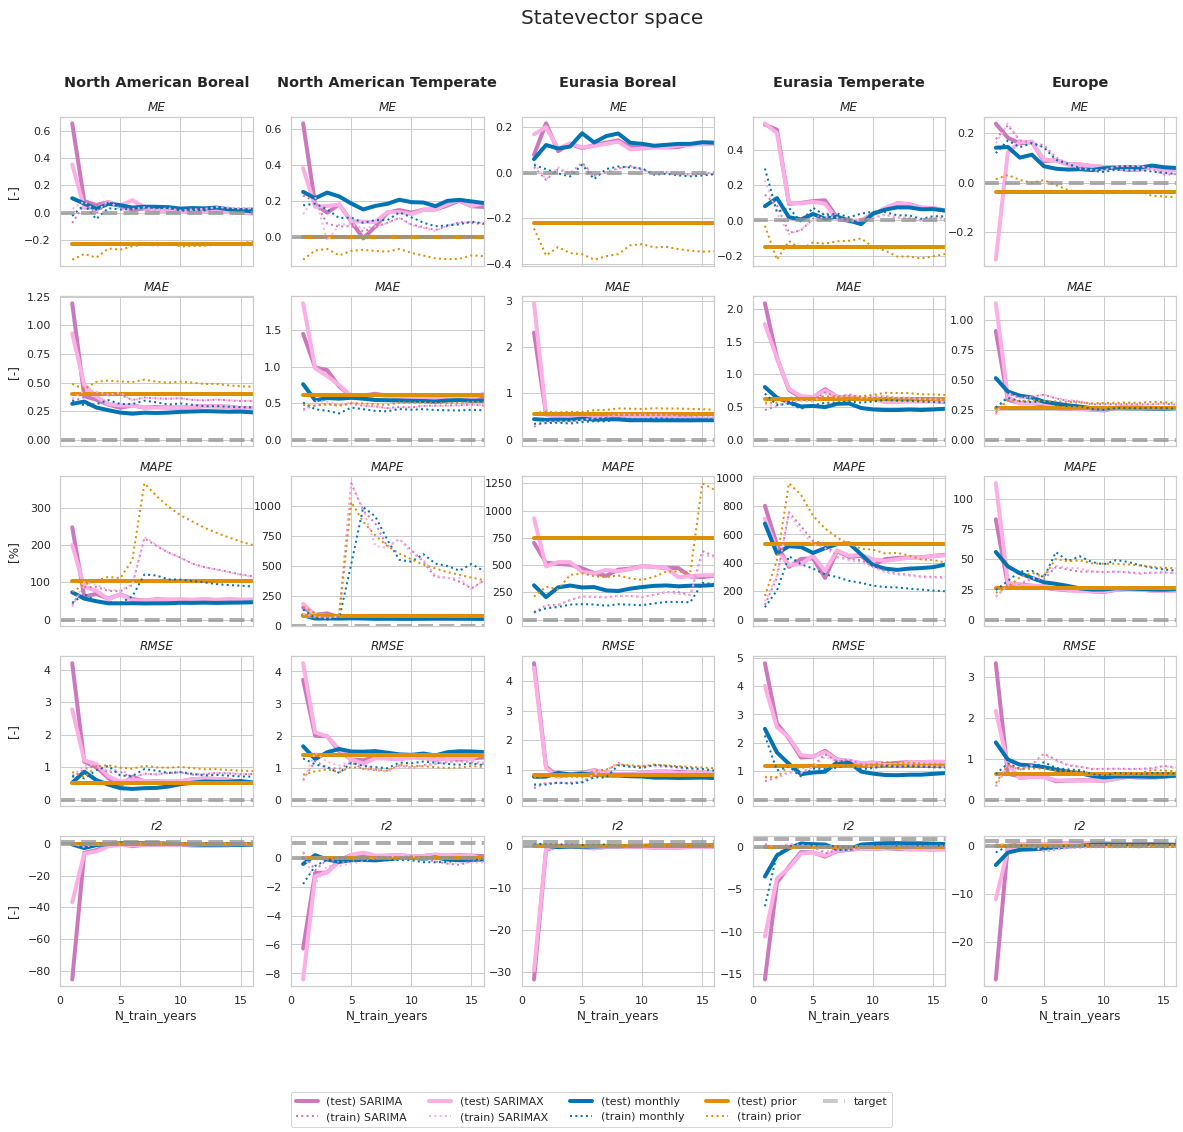

In [11]:

used_perf_measures = ['ME', 'MAE', 'MAPE', 'RMSE', 'r2']

tc_groups = results_df.groupby(['tc_region'])
tc_regions = list(tc_groups.groups.keys())


eval_space = 'sf'

y_labels = {'flux':[r'[$\mathrm{PgC\cdot yr^{-1}}$]', r'[$\mathrm{PgC\cdot yr^{-1}}$]', '[%]', r'[$\mathrm{PgC\cdot yr^{-1}}$]', '[-]'],
            'sf':['[-]', '[-]', '[%]', '[-]', '[-]']}


#sns.set(style="whitegrid", palette="pastel", color_codes=True)
sns.set(style="whitegrid", palette="colorblind", color_codes=True)
pal = sns.color_palette('colorblind')
# sns.mpl.rc("figure", figsize=(10,6))


plot_train = True
model_alpha_dict = {'prior':1, # alpha TC region 1
                   'CTE2018':1, # alpha TC region 2
                   'monthly':1, # alpha TC region 7
                   'SARIMA':1, # alpha TC region 8
                   'SARIMAX':1, # alpha TC region 11
                  }

# specifiy the color of each tc_region.
model_color_dict = {'prior':1,
                 'smoothed':2,
                 'monthly':0,
                 'SARIMA':4,
                 'SARIMAX':6}

color_indices = [model_color_dict[model] for model in used_models]

colors = [pal[c] for c in color_indices]
# print(colors)
alphas = [model_alpha_dict[model] for model in used_models]
# print(alphas)
colors = [mpl.colors.to_rgba(c, a) for c, a in zip(colors, alphas)]
# print(colors)
continent_dict = {1:'North American Boreal',
                   2:'North American Temperate',
                   7:'Eurasia Boreal',
                   8:'Eurasia Temperate',
                   11:'Europe',
                  }

n_rows = len(used_perf_measures)
n_cols = len(tc_regions)

fig, ax = plt.subplots(n_rows, n_cols,figsize=(20,16), sharex=True)

for j, (tc_region, tc_dat) in enumerate(tc_groups):

    tc_dat.reset_index(inplace=True)
    tc_dat.set_index(['model', 'N_train_years'], inplace=True)
    for i, perf_mes in enumerate(used_perf_measures):

        tc_dat.unstack(['model']).xs(eval_space+'_'+perf_mes + '_test', axis=1).plot(color=colors, ax=ax[i][j], legend=False, linewidth = 4, sort_columns=True)

        if plot_train:
            tc_dat.unstack(['model']).xs(eval_space+'_'+perf_mes + '_train', axis=1).plot(color=colors, ax=ax[i][j], legend=False, linestyle=':', linewidth = 2, sort_columns=True)

        ax[i][j].set_title(perf_mes, style='italic')
        ax[i][j].set_title(perf_mes, style='italic')

for i in range(n_rows):
    for j in range(n_cols):
        ax[i][j].axhline(y=0.0, color=pal[7], alpha=0.5, linestyle='--', label='target', linewidth = 4)
        ax[i][j].axhline(y=0.0, color=pal[7], alpha=0.5, linestyle='--', label='target', linewidth = 4)

for i in range(n_rows):
    # ax[i][0].text(x = -0.8, y = 5, s = "row label", rotation = 90, va = "center")
    ax[i][0].set_ylabel(y_labels[eval_space][i])

if 'r2' in used_perf_measures:
    for j in range(n_cols):
        ax[n_rows-1][j].axhline(y=1.0, color=pal[7], alpha=0.5, linestyle='--', label='target', linewidth = 4)
        ax[n_rows-1][j].axhline(y=1.0, color=pal[7], alpha=0.5, linestyle='--', label='target', linewidth = 4)


pad = 30 # in points
#

figure_title = "Statevector space" if eval_space == 'sf' else "Flux space"
ax[0][0].annotate(figure_title, xy=(.425, .975), xycoords='figure fraction',
            horizontalalignment='center', verticalalignment='top',
            fontsize=20)


col_names = [continent_dict[int(tc_region)] for tc_region in tc_regions]
for axes, col_name in zip(ax[0], col_names):
    axes.annotate(col_name, xy=(0.5, 1), xytext=(0, pad),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline', fontweight="bold")
#
# continent_dict = {1:'North American Boreal',
#                    2:'North American Temperate',
#                    7:'Eurasia Boreal',
#                    8:'Eurasia Temperate',
#                    11:'Europe',
#                   }

original_handles, original_labels = ax[0][0].get_legend_handles_labels()

len_legend = 2*len(used_models)+1 if plot_train else len(used_models)+1


handles = original_handles[:-1]#[None] * len_legend
# handles[-1] = original_handles[-1]

# labels = [None] * len_legend
# labels = original_labels[:-1]

test_labels = ['(test) ' + label for label in original_labels[:len(used_models)]]
print(test_labels)

# for i, label in enumerate(original_labels[:len(used_models)]):
#     labels[i] = '(test) ' + label

if plot_train:
    # overly complicated method for determining the order in which the elements from the legend should be ordered, essentially 'zipping' two lists
    legend_order = sum([[te_lab, tr_lab] for te_lab, tr_lab in zip(range(len(used_models)), range(len(used_models), len(used_models)*2))], [])
    legend_order = legend_order + [len_legend-1]

    train_labels = ['(train) ' + label for label in original_labels[len(used_models):len(used_models)*2]]
    # labels = [label for label in test_labels for label in train_labels]
    labels = test_labels + train_labels + [original_labels[-1]]

    # reordering the labels and handles of the legend
    labels = [labels[idx] for idx in legend_order]
    handles = [handles[idx] for idx in legend_order]
else:
    labels = test_labels +  [original_labels[-1]]

# labels = test_labels + train_labels + [original_labels[-1]]

    # for i, label in enumerate(original_labels[len(used_models):len(used_models)*2], start=len(used_models)):
    #     color = colors[i-len(used_models)]
    #     # handles[i] = mpl.lines.Line2D([0,1], [0.5,0.5], c=color, linestyle=':')
    #     labels[i] ='(train) ' + label


    # handles = np.concatenate([handles, mpl.lines.Line2D([0,1], [0.5,0.5], color=colors[idx*19], label=tc_region+'_test')])
plt.xlim([0,16])

fig.align_ylabels(ax)

# plt.tight_layout()

fig.subplots_adjust(right=0.9)   ##  Need to play with this number to make column names and legend fit.

fig.legend(handles, labels, loc="lower center", ncol=len(used_models)+1)

# plt.legend()
# plt.tight_layout()
plt.show()

In [ ]:
sum([[te_lab, tr_lab] for te_lab, tr_lab in zip(range(3), range(3,6))], [])


[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745), (0.8705882352941177, 0.5607843137254902, 0.0196078431372549), (0.00784313725490196, 0.6196078431372549, 0.45098039215686275), (0.8352941176470589, 0.3686274509803922, 0.0), (0.8, 0.47058823529411764, 0.7372549019607844)]
[0.5, 0.5, 0.5, 0.5, 1]
[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745, 0.5), (0.8705882352941177, 0.5607843137254902, 0.0196078431372549, 0.5), (0.00784313725490196, 0.6196078431372549, 0.45098039215686275, 0.5), (0.8352941176470589, 0.3686274509803922, 0.0, 0.5), (0.8, 0.47058823529411764, 0.7372549019607844, 1)]


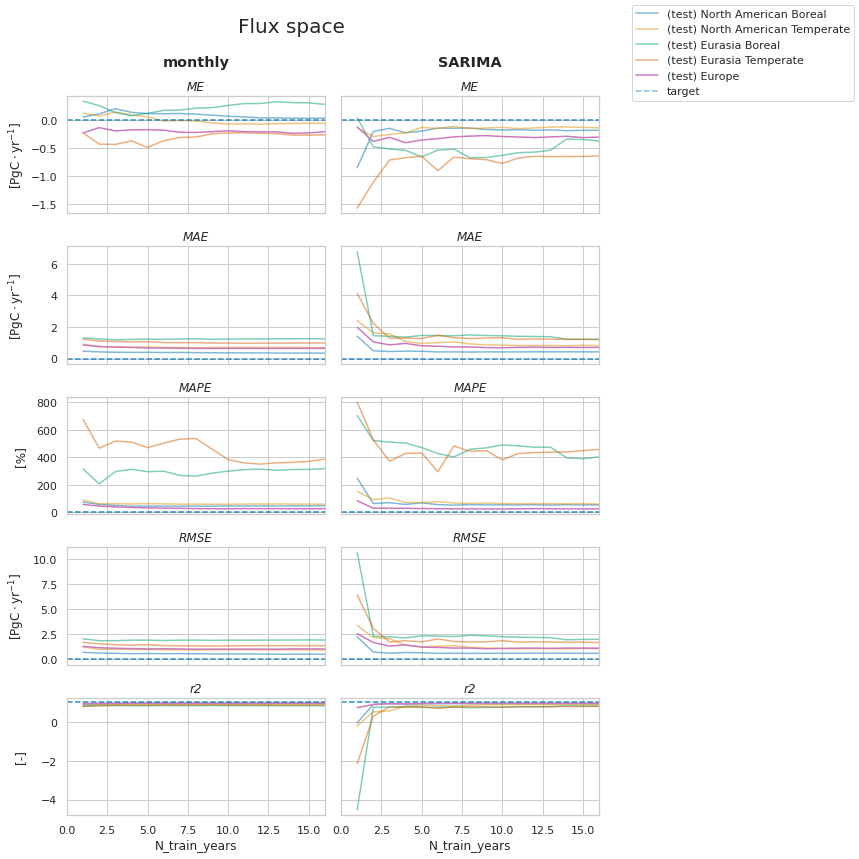

In [7]:
def mol_per_sec_to_PgC_per_year(df):
    fac= 86400.*365.*12./1e15 # from mol/region/s to PgC/yr
    for var in ['flux_ME_test', 'flux_ME_train', 'flux_MAE_test', 'flux_MAE_train', 'flux_RMSE_test', 'flux_RMSE_train']:
        df[var] = df[var]*fac
    return df


def load_results(model_name):
    file_name = RESULTS_DIR + model_name + '_results_per_tc.pkl'
    df = pd.read_pickle(file_name)
    df = mol_per_sec_to_PgC_per_year(df)
    return df.set_index(['N_train_years','tc_region'])

used_models = ['monthly', 'SARIMA']

used_perf_measures = ['ME', 'MAE', 'MAPE', 'RMSE', 'r2']

eval_space = 'flux'

y_labels = {'flux':[r'[$\mathrm{PgC\cdot yr^{-1}}$]', r'[$\mathrm{PgC\cdot yr^{-1}}$]', '[%]', r'[$\mathrm{PgC\cdot yr^{-1}}$]', '[-]'],
            'sf':['[-]', '[-]', '[%]', '[-]', '[-]']}

results_dict = {model_name: load_results(model_name) for model_name in used_models}

#sns.set(style="whitegrid", palette="pastel", color_codes=True)
sns.set(style="whitegrid", palette="colorblind", color_codes=True)
pal = sns.color_palette('colorblind')
# sns.mpl.rc("figure", figsize=(10,6))


plot_train = False
trans_alpha_dict = {1:0.5, # alpha TC region 1
                   2:0.5, # alpha TC region 2
                   7:0.5, # alpha TC region 7
                   8:0.5, # alpha TC region 8
                   11:1, # alpha TC region 11
                  }

# specifiy the color of each tc_region.
tc_color_dict = {1:0,
                 2:1,
                 7:2,
                 8:3,
                 11:4}

colors = [pal[c] for c in tc_color_dict.values()]
print(colors)
alphas = list(trans_alpha_dict.values())
print(alphas)
colors = [mpl.colors.to_rgba(c, a) for c, a in zip(colors, alphas)]
print(colors)
continent_dict = {1:'North American Boreal',
                   2:'North American Temperate',
                   7:'Eurasia Boreal',
                   8:'Eurasia Temperate',
                   11:'Europe',
                  }

n_rows = len(used_perf_measures)
n_cols = len(used_models)

fig, ax = plt.subplots(n_rows, n_cols,figsize=(12,12), sharex=True, sharey='row')

for i, perf_mes in enumerate(used_perf_measures):
    for j, (model, df) in enumerate(results_dict.items()):

        if plot_train:
            df.unstack(['tc_region']).xs(eval_space+'_'+perf_mes + '_train', axis=1).plot(color=colors, ax=ax[i][j], legend=False, linestyle=':')

        df.unstack(['tc_region']).xs(eval_space+'_'+perf_mes + '_test', axis=1).plot(color=colors, ax=ax[i][j], legend=False)

        ax[i][j].set_title(perf_mes, style='italic')
        ax[i][j].set_title(perf_mes, style='italic')

for i in range(n_rows-1):
    for j in range(n_cols):
        ax[i][j].axhline(y=0.0, color='b', alpha=0.5, linestyle='--', label='target')
        ax[i][j].axhline(y=0.0, color='b', alpha=0.5, linestyle='--', label='target')

for i in range(n_rows):
    # ax[i][0].text(x = -0.8, y = 5, s = "row label", rotation = 90, va = "center")
    ax[i][0].set_ylabel(y_labels[eval_space][i])

for j in range(n_cols):
    ax[n_rows-1][j].axhline(y=1.0, color='b', alpha=0.5, linestyle='--', label='target')
    ax[n_rows-1][j].axhline(y=1.0, color='b', alpha=0.5, linestyle='--', label='target')

original_handles, original_labels = ax[0][0].get_legend_handles_labels()

pad = 30 # in points
#

figure_title = "Statevector space" if eval_space == 'sf' else "Flux space"
ax[0][0].annotate(figure_title, xy=(.275, .975), xycoords='figure fraction',
            horizontalalignment='left', verticalalignment='top',
            fontsize=20)

for axes, col_name in zip(ax[0], used_models):
    axes.annotate(col_name, xy=(0.5, 1), xytext=(0, pad),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline', fontweight="bold")

continent_dict = {1:'North American Boreal',
                   2:'North American Temperate',
                   7:'Eurasia Boreal',
                   8:'Eurasia Temperate',
                   11:'Europe',
                  }


len_legend = 10 if plot_train else 5
handles = [None]*(len_legend+1)
handles[-1] = original_handles[-1]

labels = [None]*(len_legend+1)
labels[-1] = original_labels[-1]

for dict_item, i in zip(continent_dict.items(),range(5)):
    color = colors[i]
    handles[i] = mpl.lines.Line2D([0,1], [0.5,0.5], c=color)
    labels[i] = '(test) ' + dict_item[1]

if plot_train:
    for dict_item, i in zip(continent_dict.items(),range(int(len_legend/2), len_legend)):
        color = colors[i-5]
        handles[i] = mpl.lines.Line2D([0,1], [0.5,0.5], c=color, linestyle=':')
        labels[i] ='(train) ' + dict_item[1]


    # handles = np.concatenate([handles, mpl.lines.Line2D([0,1], [0.5,0.5], color=colors[idx*19], label=tc_region+'_test')])
plt.xlim([0,16])

fig.align_ylabels(ax)

plt.tight_layout()

fig.subplots_adjust(right=0.7)   ##  Need to play with this number to make column names and legend fit.

fig.legend(handles, labels, loc="upper right", ncol=1)

# plt.legend()
# plt.tight_layout()
plt.show()

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745), (0.8705882352941177, 0.5607843137254902, 0.0196078431372549), (0.00784313725490196, 0.6196078431372549, 0.45098039215686275), (0.8352941176470589, 0.3686274509803922, 0.0), (0.8, 0.47058823529411764, 0.7372549019607844)]
[1, 1, 1, 1, 1]
[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745, 1), (0.8705882352941177, 0.5607843137254902, 0.0196078431372549, 1), (0.00784313725490196, 0.6196078431372549, 0.45098039215686275, 1), (0.8352941176470589, 0.3686274509803922, 0.0, 1), (0.8, 0.47058823529411764, 0.7372549019607844, 1)]


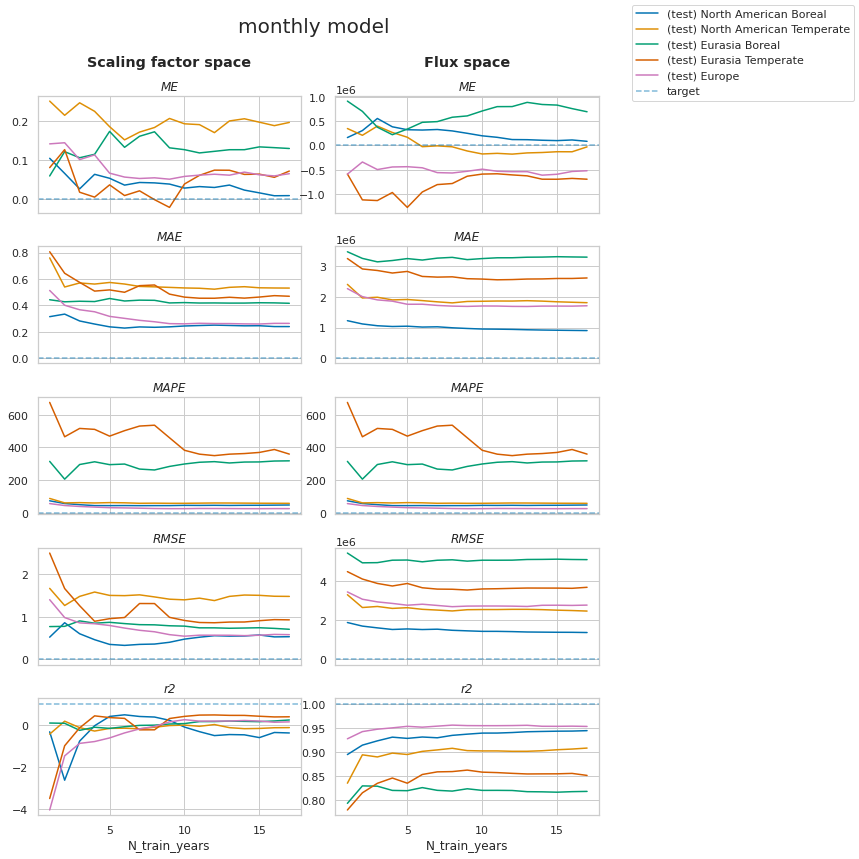

In [9]:
import seaborn as sns

model_name = 'monthly'

#sns.set(style="whitegrid", palette="pastel", color_codes=True)
sns.set(style="whitegrid", palette="colorblind", color_codes=True)
pal = sns.color_palette('colorblind')
sns.mpl.rc("figure", figsize=(10,6))

results = pd.read_pickle(RESULTS_DIR + model_name + '_results_per_tc.pkl')
results = results.set_index(['N_train_years','tc_region'])
plot_train = False
trans_alpha_dict = {1:1, # alpha TC region 1
                   2:1, # alpha TC region 2
                   7:1, # alpha TC region 7
                   8:1, # alpha TC region 8
                   11:1, # alpha TC region 11
                  }

# specifiy the color of each tc_region.
tc_color_dict = {1:0,
                 2:1,
                 7:2,
                 8:3,
                 11:4}

colors = [pal[c] for c in tc_color_dict.values()]
print(colors)
alphas = list(trans_alpha_dict.values())
print(alphas)
colors = [mpl.colors.to_rgba(c, a) for c, a in zip(colors, alphas)]
print(colors)
continent_dict = {1:'North American Boreal',
                   2:'North American Temperate',
                   7:'Eurasia Boreal',
                   8:'Eurasia Temperate',
                   11:'Europe',
                  }
fig, ax = plt.subplots(5,2,figsize=(12,12), sharex=True)

for i, perf_mes in enumerate(['ME', 'MAE', 'MAPE', 'RMSE', 'r2']):
    if plot_train:
        results.unstack(['tc_region']).xs('sf_'+perf_mes + '_train', axis=1).plot(color=colors, ax=ax[i][0], legend=False, linestyle=':')

        results.unstack(['tc_region']).xs('flux_'+perf_mes + '_train', axis=1).plot(color=colors, ax=ax[i][1], legend=False, linestyle=':')

    results.unstack(['tc_region']).xs('sf_'+perf_mes + '_test', axis=1).plot(color=colors, ax=ax[i][0], legend=False)

    results.unstack(['tc_region']).xs('flux_'+perf_mes + '_test', axis=1).plot(color=colors, ax=ax[i][1], legend=False)
    #
    # df.plot('N_train_years', 'sf_'+perf_mes + '_train', ax=ax[i][0], label='train_'+str(label), color=color_dict[label], linestyle=':')
    # df.plot('N_train_years', 'flux_'+perf_mes + '_train', ax=ax[i][1], label='train_'+str(label), color=color_dict[label], linestyle=':')
    # df.plot('N_train_years', 'sf_'+perf_mes + '_test', ax=ax[i][0], label='test_'+str(label), color=color_dict[label])
    # df.plot('N_train_years', 'flux_'+perf_mes + '_test', ax=ax[i][1], label='test_'+str(label), color=color_dict[label])
    ax[i][0].set_title(perf_mes, style='italic')
    ax[i][1].set_title(perf_mes, style='italic')

for i in range(4):
    ax[i][0].axhline(y=0.0, color='b', alpha=0.5, linestyle='--', label='target')
    ax[i][1].axhline(y=0.0, color='b', alpha=0.5, linestyle='--', label='target')

ax[4][0].axhline(y=1.0, color='b', alpha=0.5, linestyle='--', label='target')
ax[4][1].axhline(y=1.0, color='b', alpha=0.5, linestyle='--', label='target')

original_handles, original_labels = ax[0][0].get_legend_handles_labels()

pad = 30 # in points

ax[0][0].annotate(model_name + ' model', xy=(.275, .975), xycoords='figure fraction',
            horizontalalignment='left', verticalalignment='top',
            fontsize=20)

for ax, col_name in zip(ax[0], ['Scaling factor space', 'Flux space']):
    ax.annotate(col_name, xy=(0.5, 1), xytext=(0, pad),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline', fontweight="bold")

continent_dict = {1:'North American Boreal',
                   2:'North American Temperate',
                   7:'Eurasia Boreal',
                   8:'Eurasia Temperate',
                   11:'Europe',
                  }


len_legend = 10 if plot_train else 5
handles = [None]*(len_legend+1)
handles[-1] = original_handles[-1]

labels = [None]*(len_legend+1)
labels[-1] = original_labels[-1]

for dict_item, i in zip(continent_dict.items(),range(5)):
    color = colors[i]
    handles[i] = mpl.lines.Line2D([0,1], [0.5,0.5], c=color)
    labels[i] = '(test) ' + dict_item[1]

if plot_train:
    for dict_item, i in zip(continent_dict.items(),range(int(len_legend/2), len_legend)):
        color = colors[i-5]
        handles[i] = mpl.lines.Line2D([0,1], [0.5,0.5], c=color, linestyle=':')
        labels[i] ='(train) ' + dict_item[1]


    # handles = np.concatenate([handles, mpl.lines.Line2D([0,1], [0.5,0.5], color=colors[idx*19], label=tc_region+'_test')])
plt.tight_layout()

fig.subplots_adjust(right=0.7)   ##  Need to play with this number to make column names and legend fit.

fig.legend(handles, labels, loc="upper right", ncol=1)

# plt.legend()
# plt.tight_layout()
plt.show()

       start_year  N_train_years  N_train_obs  N_test_years  N_test_obs  \
1.0          2016              1           53             4         208   
1.0          2015              2          105             4         208   
1.0          2014              3          157             4         208   
1.0          2013              4          209             4         208   
1.0          2012              5          261             4         208   
...           ...            ...          ...           ...         ...   
209.0        2004             13          679             4         208   
209.0        2003             14          731             4         208   
209.0        2002             15          783             4         208   
209.0        2001             16          835             4         208   
209.0        2000             17          888             4         208   

       eco_region   sf_ME_train  sf_MAE_train  sf_MAPE_train  sf_RMSE_train  \
1.0           1.0 -1

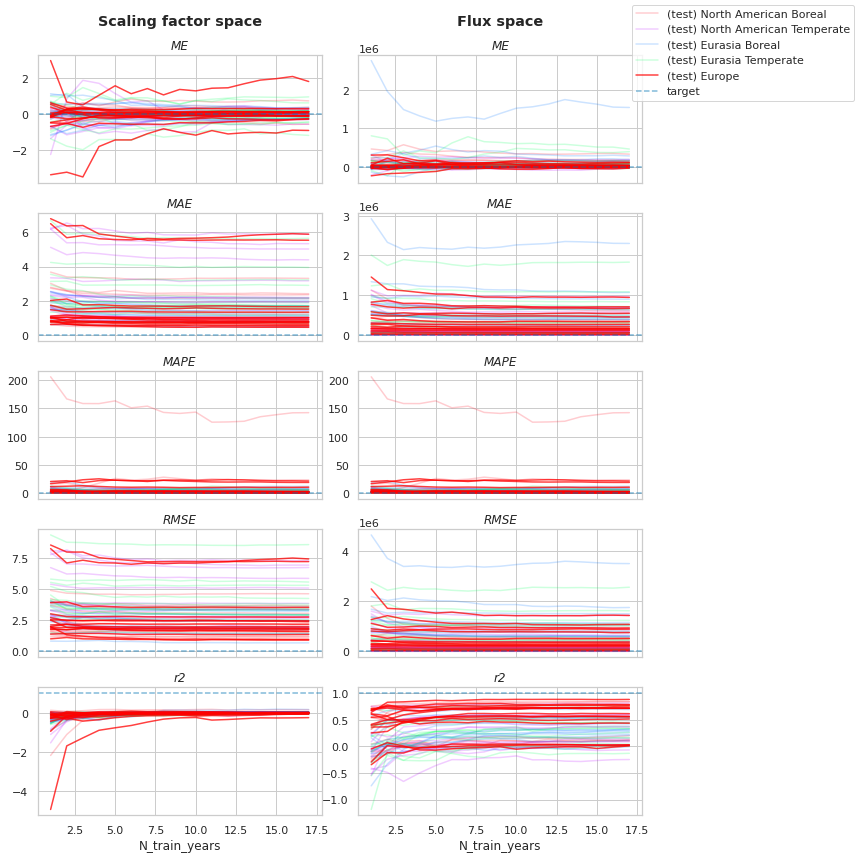

In [44]:
def det_colors(regions, color_ranges):
    color_pos = np.interp(regions,
                     [1,19,20,38,115,133,134,152,190,209],
                     np.concatenate(list(color_ranges.values())))
    return plt.cm.hsv_r(color_pos)

plot_train = False

results = pd.read_pickle(RESULTS_DIR + 'SARIMA_results.pkl')
print(results)
regions = np.unique(results.eco_region)


results = results.set_index(['N_train_years','eco_region'])
trans_color_dict = {1:[0,0], # color TC region 1
                   2:[0.2, 0.2], # color TC region 2
                   7:[0.4, 0.4], # color TC region 7
                   8:[0.6, 0.6], # color TC region 8
                   11:[1,1], # color TC region 11
                  }

trans_alpha_dict = {1:0.2, # alpha TC region 1
                   2:0.2, # alpha TC region 2
                   7:0.2, # alpha TC region 7
                   8:0.2, # alpha TC region 8
                   11:0.75, # alpha TC region 11
                  }

continent_dict = {1:'North American Boreal',
                   2:'North American Temperate',
                   7:'Eurasia Boreal',
                   8:'Eurasia Temperate',
                   11:'Europe',
                  }

colors = det_colors(regions, trans_color_dict)
alphas = [trans_alpha_dict[int((r-1)/19)+1] for r in regions]

colors[:,-1] = alphas
#
# transcom_colors = plt.cm.rainbow(np.linspace(0, 1, 5))
#
# color_dict = {key: color for key, color in zip(range(1,20),europe_colors)}

# colors = colors[:len(regions)]
# results.groupby('eco_region').plot('start_year', 'flux_MAE_test')
fig, ax = plt.subplots(5,2,figsize=(12,12), sharex=True)

for i, perf_mes in enumerate(['ME', 'MAE', 'MAPE', 'RMSE', 'r2']):
    if plot_train:
        results.unstack(['eco_region']).xs('sf_'+perf_mes + '_train', axis=1).plot(color=colors, ax=ax[i][0], legend=False, linestyle=':')

        results.unstack(['eco_region']).xs('flux_'+perf_mes + '_train', axis=1).plot(color=colors, ax=ax[i][1], legend=False, linestyle=':')

    results.unstack(['eco_region']).xs('sf_'+perf_mes + '_test', axis=1).plot(color=colors, ax=ax[i][0], legend=False)

    results.unstack(['eco_region']).xs('flux_'+perf_mes + '_test', axis=1).plot(color=colors, ax=ax[i][1], legend=False)
    #
    # df.plot('N_train_years', 'sf_'+perf_mes + '_train', ax=ax[i][0], label='train_'+str(label), color=color_dict[label], linestyle=':')
    # df.plot('N_train_years', 'flux_'+perf_mes + '_train', ax=ax[i][1], label='train_'+str(label), color=color_dict[label], linestyle=':')
    # df.plot('N_train_years', 'sf_'+perf_mes + '_test', ax=ax[i][0], label='test_'+str(label), color=color_dict[label])
    # df.plot('N_train_years', 'flux_'+perf_mes + '_test', ax=ax[i][1], label='test_'+str(label), color=color_dict[label])
    ax[i][0].set_title(perf_mes, style='italic')
    ax[i][1].set_title(perf_mes, style='italic')

for i in range(4):
    ax[i][0].axhline(y=0.0, color='b', alpha=0.5, linestyle='--', label='target')
    ax[i][1].axhline(y=0.0, color='b', alpha=0.5, linestyle='--', label='target')

ax[4][0].axhline(y=1.0, color='b', alpha=0.5, linestyle='--', label='target')
ax[4][1].axhline(y=1.0, color='b', alpha=0.5, linestyle='--', label='target')
original_handles, original_labels = ax[0][0].get_legend_handles_labels()

pad = 30 # in points

for ax, col_name in zip(ax[0], ['Scaling factor space', 'Flux space']):
    ax.annotate(col_name, xy=(0.5, 1), xytext=(0, pad),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline', fontweight="bold")

continent_dict = {1:'North American Boreal',
                   2:'North American Temperate',
                   7:'Eurasia Boreal',
                   8:'Eurasia Temperate',
                   11:'Europe',
                  }


len_legend = 10 if plot_train else 5
handles = [None]*(len_legend+1)
handles[-1] = original_handles[-1]

labels = [None]*(len_legend+1)
labels[-1] = original_labels[-1]


for dict_item, i in zip(continent_dict.items(),range(5)):
    color = list(det_colors(dict_item[0]*19, trans_color_dict))
    color[-1] = trans_alpha_dict[dict_item[0]]
    handles[i] = mpl.lines.Line2D([0,1], [0.5,0.5], c=color)
    labels[i] = '(test) ' + dict_item[1]

if plot_train:
    for dict_item, i in zip(continent_dict.items(),range(len_legend/2, len_legend)):
        color = list(det_colors(dict_item[0]*19, trans_color_dict))
        color[-1] = trans_alpha_dict[dict_item[0]]
        handles[i] = mpl.lines.Line2D([0,1], [0.5,0.5], c=color, linestyle=':')
        labels[i] ='(train) ' + dict_item[1]


    # handles = np.concatenate([handles, mpl.lines.Line2D([0,1], [0.5,0.5], color=colors[idx*19], label=tc_region+'_test')])
plt.tight_layout()

fig.subplots_adjust(right=0.75)   ##  Need to play with this number to make column names and legend fit.

fig.legend(handles, labels, loc="upper right", ncol=1)


# handles, _ = ax[4][0]
# handles.append(ax[4][0].axhline(y=1.0, color='b', alpha=0.5, linestyle='--', label='target'))
#
# handles, _ = ax[4][1].get_legend_handles_labels()
# handles.append(ax[4][1].axhline(y=1.0, color='b', alpha=0.5, linestyle='--', label='target'))


# plt.legend()
plt.show()

In [34]:
labels = ["some name", "some other name", "horizontal"]
handles